# End to End Data Science Life Cycle

![Data Science Life Cycle](https://www.edushots.com/upload/articles-images/8990b754abdbe6a2d6e3dcfad3473541623b8c4c.jpg)

# 1- Problem Understanding

**What is the Goal of the Competition ?**
* build a model to predict the market (responder_6) for the next 6 months using real-world data derived from production systems, which offers a glimpse into the daily challenges of successful trading.

**What Challenges Will We Face in Financial Market Modeling ?**
1. fat-tailed distributions
2. non-stationary time series
3. sudden shifts in market behavior

**What Metric Will Define Success?**
* The competition uses the Sample Weighted Zero-Mean R-Squared Score as the evaluation metric.

#  2- Data Understanding 

In [59]:
import pandas as pd
import os
from glob import glob
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
path = "/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet"

# Automatically detect partitions instead of manually specifying them
partition_paths = sorted(glob(os.path.join(path, "partition_id=*/part-*.parquet")))

# Select a range of files 
first_partitions_to_load = 0
last_partitions_to_load = 2
selected_files = partition_paths[first_partitions_to_load:last_partitions_to_load]

dataframes = []

for file in selected_files:
    try:
        df_part = pd.read_parquet(file)
        dataframes.append(df_part)
    except Exception as e:
        print(f"Error reading {file}: {e}")

sample_df = pd.concat(dataframes, ignore_index=True)

print("Loaded shape:", sample_df.shape)
sample_df.head()

Loaded shape: (4748457, 92)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,0,0,1,3.889038,NaN,NaN,NaN,NaN,NaN,0.851033,0.242971,0.263400,-0.891687,11,7,76,-0.883028,0.003067,-0.744703,NaN,-0.169586,NaN,-1.335938,-1.707803,0.910130,NaN,1.636431,1.522133,-1.551398,-0.229627,NaN,NaN,1.378301,-0.283712,0.123196,NaN,NaN,NaN,0.281180,0.269163,0.349028,-0.012596,-0.225932,NaN,-1.073602,NaN,NaN,-0.181716,NaN,NaN,NaN,0.564021,2.088506,0.832022,NaN,0.204797,NaN,NaN,-0.808103,NaN,-2.037683,0.727661,NaN,-0.989118,-0.345213,-1.36224,NaN,NaN,NaN,NaN,NaN,-1.251104,-0.110252,-0.491157,-1.022690,0.152241,-0.659864,NaN,NaN,-0.261412,-0.211486,-0.335556,-0.281498,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504
1,0,0,7,1.370613,NaN,NaN,NaN,NaN,NaN,0.676961,0.151984,0.192465,-0.521729,11,7,76,-0.865307,-0.225629,-0.582163,NaN,0.317467,NaN,-1.250016,-1.682929,1.412757,NaN,0.520378,0.744132,-0.788658,0.641776,NaN,NaN,0.227200,0.580907,1.128879,NaN,NaN,NaN,-1.512286,-1.414357,-1.823322,-0.082763,-0.184119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.835207,-0.002704,-0.621836,NaN,1.172836,NaN,NaN,-1.625862,NaN,-1.410017,1.063013,NaN,0.888355,0.467994,-1.36224,NaN,NaN,NaN,NaN,NaN,-1.065759,0.013322,-0.592855,-1.052685,-0.393726,-0.741603,NaN,NaN,-0.281207,-0.182894,-0.245565,-0.302441,2.965889,1.190077,-0.523998,3.849921,2.626981,5.000000,0.703665,0.216683,0.778639
2,0,0,9,2.285698,NaN,NaN,NaN,NaN,NaN,1.056285,0.187227,0.249901,-0.773050,11,7,76,-0.675719,-0.199404,-0.586798,NaN,-0.814909,NaN,-1.296782,-2.040234,0.639589,NaN,1.597359,0.657514,-1.350148,0.364215,NaN,NaN,-0.017751,-0.317361,-0.122379,NaN,NaN,NaN,-0.320921,-0.958090,-2.436589,0.070999,-0.245239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.420632,-3.515137,-4.677760,NaN,0.535897,NaN,NaN,-0.725420,NaN,-2.294170,1.764551,NaN,-0.120789,-0.063458,-1.36224,NaN,NaN,NaN,NaN,NaN,-0.882604,-0.072482,-0.617934,-0.863230,-0.241892,-0.709919,NaN,NaN,0.377131,0.300724,-0.106842,-0.096792,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828
3,0,0,10,0.690606,NaN,NaN,NaN,NaN,NaN,1.139366,0.273328,0.306549,-1.262223,42,5,150,-0.694008,3.004091,0.114809,NaN,-0.251882,NaN,-1.902009,-0.979447,0.241165,NaN,-0.392359,-0.224699,-2.129397,-0.855287,NaN,NaN,0.404142,-0.578156,0.105702,NaN,NaN,NaN,0.544138,-0.087091,-1.500147,-0.201288,-0.038042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.382074,2.669135,0.611711,NaN,2.413415,NaN,NaN,1.313203,NaN,-0.810125,2.939022,NaN,3.988801,1.834661,-1.36224,NaN,NaN,NaN,NaN,NaN,-0.697595,1.074309,-0.206929,-0.530602,4.765215,0.571554,NaN,NaN,-0.226891,-0.251412,-0.215522,-0.296244,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516
4,0,0,14,0.440570,NaN,NaN,NaN,NaN,NaN,0.955200,0.262404,0.344457,-0.613813,44,3,16,-0.947351,-0.030018,-0.502379,NaN,0.646086,NaN,-1.844685,-1.586560,-0.182024,NaN,-0.969949,-0.673813,-1.282132,-1.399894,NaN,NaN,0.043815,-0.320225,-0.031713,NaN,NaN,NaN,-0.088420,-0.995003,-2.635336,-0.196461,-0.618719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.014600,-2.321076,-3.711265,N

In [54]:
# Data Info
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4748457 entries, 0 to 4748456
Data columns (total 92 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date_id      int16  
 1   time_id      int16  
 2   symbol_id    int8   
 3   weight       float32
 4   feature_00   float32
 5   feature_01   float32
 6   feature_02   float32
 7   feature_03   float32
 8   feature_04   float32
 9   feature_05   float32
 10  feature_06   float32
 11  feature_07   float32
 12  feature_08   float32
 13  feature_09   int8   
 14  feature_10   int8   
 15  feature_11   int16  
 16  feature_12   float32
 17  feature_13   float32
 18  feature_14   float32
 19  feature_15   float32
 20  feature_16   float32
 21  feature_17   float32
 22  feature_18   float32
 23  feature_19   float32
 24  feature_20   float32
 25  feature_21   float32
 26  feature_22   float32
 27  feature_23   float32
 28  feature_24   float32
 29  feature_25   float32
 30  feature_26   float32
 31  feature_27   float32
 32

In [55]:
# Describe data
sample_df.describe()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
count,4.748457e+06,4.748457e+06,4.748457e+06,4.748457e+06,1.566405e+06,1.566405e+06,1.566405e+06,1.566405e+06,1.566405e+06,4.748457e+06,4.748457e+06,4.748457e+06,4.731477e+06,4.748457e+06,4.748457e+06,4.748457e+06,4.748457e+06,4.748457e+06,4.748457e+06,4.614176e+06,4.748353e+06,4.725958e+06,4.748369e+06,4.748369e+06,4.748457e+06,0.0,4.748457e+06,4.748457e+06,4.748457e+06,4.748457e+06,0.0,0.0,4.748457e+06,4.748457e+06,4.748457e+06,0.0,4.695265e+06,4.695265e+06,4.748457e+06,4.748457e+06,4.748457e+06,4.748457e+06,4.748457e+06,3.991170e+06,4.695290e+06,4.548888e+06,3.991170e+06,4.695290e+06,4.548888e+06,4.492023e+06,4.492023e+06,4.748370e+06,4.748457e+06,4.748457e+06,4.032553e+06,4.742864e+06,4.591853e+06,4.032553e+06,4.742864e+06,4.591853e+06,4.748369e+06,4.748369e+06,4.695270e+06,4.748457e+06,4.748457e+06,4.748457e+06,4.512634e+06,4.552024e+06,4.545981e+06,4.492023e+06,4.492023e+06,4.748457e+06,4.748457e+06,4.748457e+06,4.748457e+06,4.748457e+06,4.748457e+06,4.695270e+06,4.695270e+06,4.748395e+06,4.748395e+06,4.748457e+06,4.748457e+06,4.748457e+06,4.748457e+06,4.748457e+06,4.748457e+06,4.748457e+06,4.748457e+06,4.748457e+06,4.748457e+06,4.748457e+06
mean,1.895017e+02,4.240000e+02,1.422099e+01,1.909972e+00,-4.319894e-01,1.717309e-02,-4.323236e-01,-4.317801e-01,3.542210e-05,5.504974e-03,1.430211e-03,4.151989e-03,2.650804e-03,3.152351e+01,4.543715e+00,1.751704e+02,-4.196147e-03,1.430388e-02,1.914006e-02,1.042857e-01,6.616154e-02,1.005071e-01,5.867705e-02,5.640617e-02,3.517781e-01,NaN,1.664986e-01,1.683540e-01,-6.530602e-01,-8.595039e-03,NaN,NaN,1.711816e-01,-1.201917e-01,1.127348e-01,NaN,-1.345844e-01,-2.339978e-03,-1.390257e-01,-1.377113e-01,-3.125289e-03,-1.536038e-02,2.577604e-03,-1.708121e-01,-1.106801e-02,-1.173356e-01,2.403709e-01,7.645616e-02,1.882000e-01,-1.576857e-01,1.948978e-01,-1.452793e-02,-5.835121e-04,-4.512480e-03,4.039864e-02,-2.956882e-02,4.094029e-02,-5.716297e-02,7.353546e-02,-1.565784e-02,-5.045044e-02,-5.584607e-04,1.180054e-03,-8.536120e-05,3.264362e-04,-2.702059e-03,4.547086e-01,3.696485e-01,3.946390e-01,1.993148e-01,1.822486e-01,-7.855630e-03,9.885056e-03,1.413029e-02,-3.334046e-03,1.277280e-02,1.994052e-02,-3.752885e-02,-3.640281e-02,-2.348619e-02,-2.249623e-02,-3.061033e-02,-2.955675e-02,7.198689e-03,1.287944e-02,2.011834e-03,3.937299e-03,9.276969e-03,-5.818280e-04,-3.506077e-03,-8.619868e-03,-1.592221e-03
std,9.326140e+01,2.450850e+02,1.105149e+01,1.033437e+00,9.885521e-01,8.246472e-01,9.892721e-01,9.881403e-01,8.342040e-01,1.027757e+00,1.019527e+00,1.042149e+00,9.268132e-01,2.526425e+01,2.379646e+00,1.791047e+02,1.012298e+00,1.079387e+00,1.017525e+00,8.821312e-01,9.947770e-01,9.342815e-01,1.023438e+00,1.033779e+00,9.975863e-01,NaN,9.887055e-01,9.351361e-01,8.450531e-01,9.830049e-01,NaN,NaN,9.337382e-01,6.731258e-01,8.759957e-01,NaN,9.269718e-01,1.176420e+00,8.620030e-01,8.667322e-01,1.163343e+00,1.008367e+00,1.014559e+00,1.317421e+00,1.415884e+00,1.385390e+00,1.308161e+00,1.411762e+00,1.369454e+00,1.213142e+00,1

In [56]:
# Check for duplicted data
sample_df.duplicated(subset=['date_id','time_id','symbol_id']).sum()

0

In [27]:
# Check for number of unique values for each column
sample_df.nunique()

date_id            340
time_id            849
symbol_id           20
weight            5593
feature_00     1547657
feature_01     1551308
feature_02     1547866
feature_03     1547961
feature_04     1550175
feature_05     4631260
feature_06     4642985
feature_07     4634244
feature_08     4604372
feature_09          11
feature_10           6
feature_11          12
feature_12     4559560
feature_13     4428424
feature_14     4533337
feature_15     4454266
feature_16     4573616
feature_17     4555568
feature_18     4599754
feature_19     4599936
feature_20        5592
feature_21           0
feature_22        5593
feature_23        5593
feature_24        5592
feature_25        5593
feature_26           0
feature_27           0
feature_28        5593
feature_29        5593
feature_30        5593
feature_31           0
feature_32     4550557
feature_33     4532755
feature_34     4596687
feature_35     4597075
feature_36     4590440
feature_37     4626565
feature_38     4622021
feature_39 

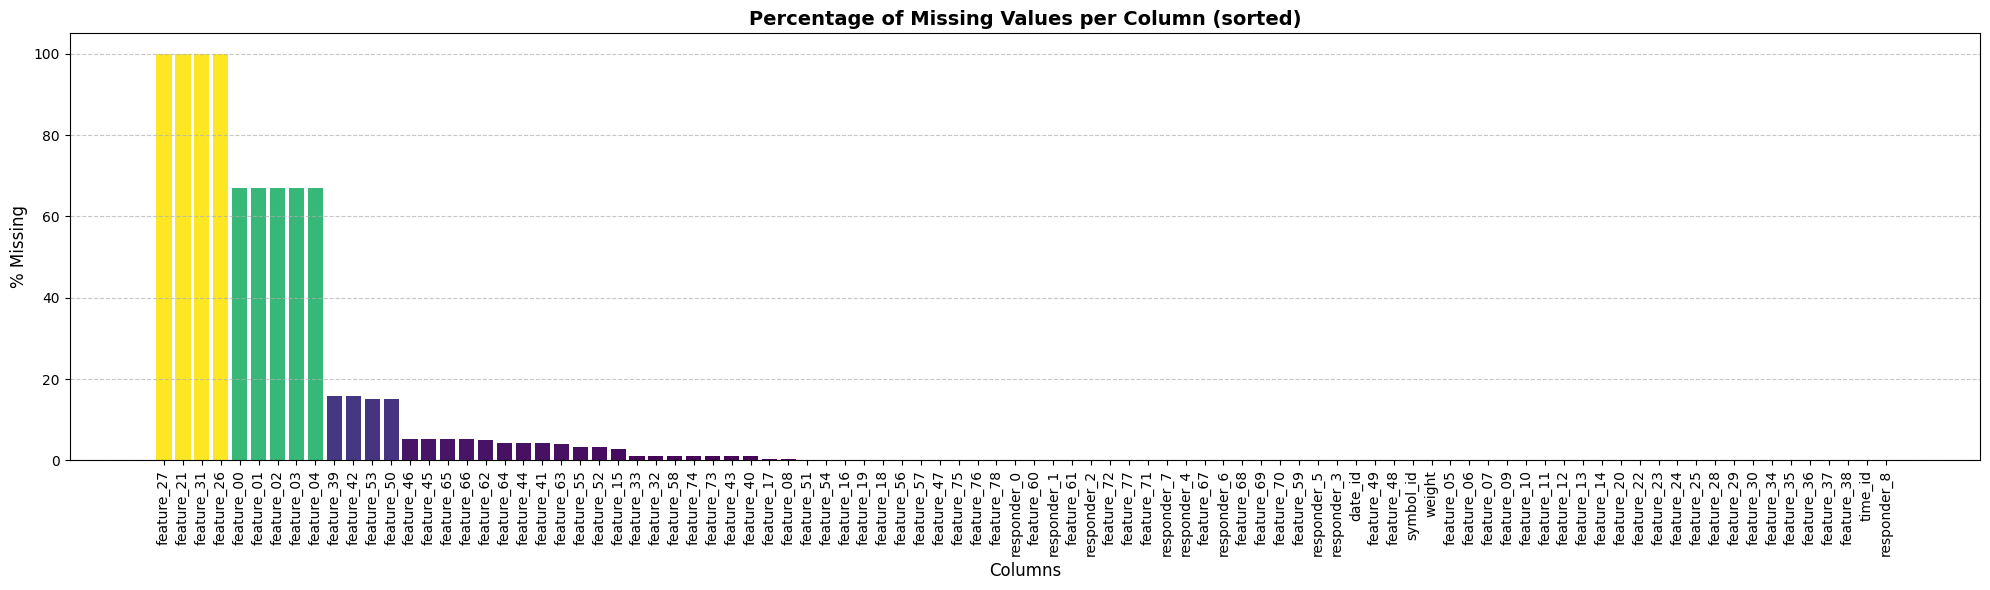

In [61]:
# Missing Ratio 
missing_ratio = sample_df.isna().mean() * 100

# Sort Missing Values Columns
missing_ratio = missing_ratio.sort_values(ascending=False)

# Plt Missing Columns
plt.figure(figsize=(20, 6))
bars = plt.bar(
    x=missing_ratio.index,
    height=missing_ratio.values,
    color=plt.cm.viridis(missing_ratio.values / max(missing_ratio.values))  
)

# Rotattion Columns
plt.xticks(rotation=90, fontsize=10)

# Titile and labels
plt.title('Percentage of Missing Values per Column (sorted)', fontsize=14, fontweight='bold')
plt.ylabel('% Missing', fontsize=12)
plt.xlabel('Columns', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
